# The inference 
We want to infer the underlying distribution of radial offsets, $p(m|\{x_i\})$, where $m$ is a model parameter and $\{x_i\}$ is the set of spectral data we have. Using Bayes' theorem:
    $$ p(m|\{x_i\}) = \frac{p(\{x_i\}|m) p(m)}{E}, $$
where $p(\{x_i\}|m)$ is the likelihood, $p(m)$ is the prior on the model parameter(s), and $E$ is the evidence.

The total likelihood is calculated from the product of likelihoods of the individual spectra we have:
$$ p(\{x_i\}|m) = \prod_i p(x_i|m), $$
We have the option here to try to derive the likelihood analytically or to forward-model it. Let's try the analytical approach first.

# Deriving likelihood analytically
We want to constrain the standard deviation of a radial offset distribution, $\sigma_r$. We cannot write this distribution function as a 1D gaussian because $r$ is part of the polar coordinate system, a 2D coordinate system. As a side note, if we start with $dp(r)/dr$ as a 1D radial gaussian then convert to $dp(x,y)/dxdy$, the y-integral to get dp(x)/dx does not converge. We can derive what the form of $dp(r)/dr$ will be if we start with a 2D Gaussian distribution in cartesian coordinates:

$$ dp(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} \exp\left(-\left(\frac{x^2}{2\sigma_x^2} + \frac{y^2}{2\sigma_y^2}\right)\right)dxdy $$
Because our distribution is symmetric in x and y:
$$\sigma_x = \sigma_y$$
So we have:
$$ dp(x,y) = \frac{1}{2\pi \sigma_x^2} \exp\left(-\frac{1}{2\sigma_x^2}(x^2 + y^2)\right)dxdy $$

Now we know that:
$$dxdy = rdrd\theta$$
$$r^2 = x^2 + y^2 $$
$$\sigma_r^2 = \sigma_x^2 + \sigma_y^2 = 2\sigma_x^2 $$

Rewriting the above now for r, theta:
$$ dp(r,\theta) = \frac{1}{\pi \sigma_r^2} \exp\left(-\frac{r^2}{\sigma_r^2}\right)rdrd\theta $$

Integrating over theta just gives $2\pi$ so $dp(r)$:
$$ dp(r) = \frac{2\pi r}{\pi \sigma_r^2} \exp\left(-\frac{r^2}{\sigma_r^2}\right)dr $$
We can check that this obeys the transformation rule:
$$ f(x,y) = \frac{f(r)}{2\pi r} \equiv \frac{1}{2\pi r} \times \frac{dp(r)}{dr},$$
where $f(x,y)$ is a probability density function in x,y cartesian coordinates and $f(r)$ is the same probability density function expressed in the r polar coordinate. This is assuming the $\theta$ probability distribution is uniform,i.e. $f(\theta) = 1/(2\pi)$, which it is in our case. Starting with the RHS:
$$\frac{f(r)}{2\pi r} = \frac{1}{2\pi r} \times \frac{dp(r)}{dr} = \frac{1}{2\pi r} \times \frac{2\pi r}{\pi \sigma_r^2} \exp\left(-\frac{r^2}{\sigma_r^2}\right) = \frac{1}{\pi \sigma_r^2} \exp\left(-\frac{r^2}{\sigma_r^2}\right) $$
Now let's change back to x and y coordinates to check if this equals $f(x,y)$:
$$\frac{f(r)}{2\pi r} = \frac{1}{2\pi \sigma_x^2} \exp\left(-\frac{1}{2\sigma_x^2}(x^2 + y^2)\right) = \frac{dp(x,y)}{dxdy} \equiv f(x,y) $$
which is what we started with, so we did the transformation correctly.

OK, but we don't measure $r$. We measure the spatial offset, $x$, in a particular slit, which is a cartesian coordinate. Right now we are assuming an infinitely narrow slit, where anything with a spatial offset $r$ gets projected to $x=rcos{\theta}$.

To get the likelihood for $x$ we need to integrate $f(x,y)$ over y:
$$ \frac{dp(x|\sigma_r)}{dx} = \int{dy \frac{1}{\pi \sigma_r^2} \exp\left(\frac{-1}{\sigma_r^2}(x^2+y^2)\right)} = \frac{1}{\pi \sigma_r^2} \exp\left(-\frac{x^2}{\sigma_r^2} \right) \int_{y=-\infty}^{y=+\infty}{dy \exp\left(-\frac{y^2}{\sigma_r^2}\right)} = \frac{1}{\pi \sigma_r^2} \exp\left(-\frac{x^2}{\sigma_r^2} \right) [\sqrt{\pi} \sigma_r ] $$ 
So our final form for the likelihood in this simple case is:
$$ \frac{dp(x|\sigma_r)}{dx} = \frac{1}{\sqrt{\pi} \sigma_r} \exp\left(-\frac{x^2}{\sigma_r^2}\right) $$
which is just a Gaussian with a modified $\sigma$: $N(0,\sigma=\sigma_r/\sqrt{2})$

# Implementation
Now that I have the likelihood function, I can use it (with the prior) for all of the spectra to obtain the combined posterior. I will use the python emcee package to do this

In [100]:
import os
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from mystats import confidence_interval


import emcee 

%matplotlib inline

home_dir = os.environ['HOME']
paper_dir = home_dir + '/Dropbox/Research/Papers/lya_offsets'
catalog_dir = paper_dir + '/catalogs_best'
mcmc_dir = paper_dir + '/mcmc'
offset_cat_gauss = catalog_dir + '/vandels_lya_offsets_gauss.txt'
good_specfiles_file = catalog_dir + '/specfiles_with_lya.txt'
bad_specfiles_file  = catalog_dir + '/specfiles_bad_opt.txt'

pixscale_vimos_spatial = 0.205 # arcsec/pix spatial scale
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

np.random.seed(0)

In [44]:
# Define the likelihood, prior and posterior to be used by emcee
def llh(sigma_r_kpc,x):
    ''' 
    ---PURPOSE---
    Evaulate a likelihood p(x|sigma_r_kpc)
    at a given value of x
    --INPUT---
    sigma_r_kpc     The width of gaussian distribution of radial offsets
                    of our particular model
    x               The value of the offset in kpc 
                    at which you want to evaluate the likelihood
    --OUTPUT--
    '''
    llh = 1/np.sqrt(np.pi)*1/sigma_r_kpc*np.exp(-(x/sigma_r_kpc)**2)
    return llh

def lnlike_4mcmc(sigma_r_kpc, offsets_kpc,):
    ''' 
    ---PURPOSE---
    Calculate the summed log-likelihood  
    for all offsets
    ---INPUT---
    sigma_r_kpc     The width of gaussian distribution of radial offsets
                    of our particular model
    x               The value of the offset in kpc 
                    at which you want to evaluate the likelihood
    --OUTPUT--
    '''
    likelihoods = np.array([llh(sigma_r_kpc,x) for x in offsets_kpc])
    return np.sum(np.log(likelihoods))
    
def lnprior_4mcmc(sigma_r_kpc):
    ''' 
    ---PURPOSE---
    Define the prior on the model parameter,
    i.e. the sigma of the radial offset distribution in kpc
    which will be used by the emcee sampler.
    Flat prior between 0.1 and 10 kpc
    ---INPUT---
    sigma_r_kpc     The width of gaussian distribution of radial offsets
                    of our particular model
    --OUTPUT--
    '''
    if 0.1<sigma_r_kpc<10.:
        return 0.0
    return -np.inf

def lnprob_4mcmc(sigma_r_kpc, offsets_kpc):
    ''' 
    ---PURPOSE---
    Calculate the log posterior 
    by summing the log llh and the log prior
    i.e. the sigma of the radial offset distribution in kpc
    which will be used by the emcee sampler.
    Flat prior between 0.1 and 10 kpc
    ---INPUT---
    sigma_r_kpc 	The width of gaussian distribution of radial offsets
                    of our particular model
    --OUTPUT--
    '''
    lp = lnprior_4mcmc(sigma_r_kpc=sigma_r_kpc)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_4mcmc(sigma_r_kpc, offsets_kpc)


def run_mcmc(verbose=True,savechain=True):
    """
    ---- PURPOSE ----
    Run the MCMC sampler and return the MCMC chain 
    from comparing the measured spatial offsets with 
    the model
    ---- INPUT ----
    verbose         if True, will print a progress 
                    report on the mcmc chain
    savechain       if True, will save a text file with the 
                    values of sigma_r_kpc at each step in the chain
    ---- OUTPUT ----
    sampler         An object containing information about the mcmc run, including the chain 
    """
    ''' Set up the data '''
    offset_tab = Table.read(offset_cat_gauss,format='ascii.commented_header')
    print "Have %i objects in the original offset table before cleaning" % len(offset_tab)
    ''' Load in the good specfiles from my visual inspection '''
    good_specfiles_tab = Table.read(good_specfiles_file,format='ascii.commented_header')
    good_specfiles = good_specfiles_tab['specfile']
    bad_indices = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] not in good_specfiles]
    offset_tab.remove_rows(bad_indices)
    ''' Now remove the specfiles which I identified as having bad optimized lya positions '''
    bad_specfiles_tab = Table.read(bad_specfiles_file,format='ascii.commented_header')
    bad_specfiles = bad_specfiles_tab['specfile']
    bad_indices2 = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] in bad_specfiles]
    offset_tab.remove_rows(bad_indices2)
    print "Have %i objects in the offset table after cleaning" % len(offset_tab)

    zs_lya = offset_tab['z_lya']
    y_lya_priors = offset_tab['y_lya_prior']
    y_lya_opts = offset_tab['y_lya_opt']
    
    offsets_pix = y_lya_priors - y_lya_opts
    offsets_arcsec = offsets_pix*pixscale_vimos_spatial
    arcsecs_per_kpc = np.array([cosmo.arcsec_per_kpc_proper(z_lya).value for z_lya in zs_lya])

    offsets_kpc = np.array([offsets_arcsec[ii]/arcsecs_per_kpc[ii] for ii in range(len(offsets_arcsec))])

    ''' set up the mcmc parameters '''

    sigma_r_min = 0.1
    sigma_r_max = 10.
    nwalkers=100 # The number of paths throught the parameter space that are taken. 100 or greater is good
    nsteps=250 # The number of steps to take in the chain. 500 recommended on emcee website

  
    ''' Now set up the sampler '''
    ndim = 1
    ''' initialize a Gaussian around the mean of the parameter range  '''
    pos = [np.array([np.mean([sigma_r_min,sigma_r_max])]) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)] 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_4mcmc, args=(offsets_kpc,))
    # lnprob_1D_contamerror(theta,zrange,magrange,mb,flux_1D,var_1D,aper,**kwargs)
    print "Optimizing for sigma_r_kpc"

    print "running sampler for %i steps with %i walkers" % (nsteps,nwalkers)

    if verbose:
        for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
            print("{0:5.1%}".format(float(i) / nsteps))
    else:
        sampler.run_mcmc(pos,nsteps)

    if savechain:
        savename = mcmc_dir + '/mcmc_chain_nwalkers%i_nsteps%i.txt' % (nwalkers,nsteps)
        print "saving %s" % savename
        np.savetxt(savename,sampler.flatchain)

    return sampler


In [45]:
# Define some plotting scripts which will plot the 
# MCMC streams and the posterior 

def read_chainfile(chain_file):
    """
    ---- PURPOSE ----
    Helper function to get information from the chain file
    ---- INPUT ----
    sampler             The MCMC sampler returned from emcee.EnsembleSampler(), for example
    grp_name            'simp', e.g.
    ---- OUTPUT ----
    samples_flat,nwalkers,nsteps, dlam, fcontam, grp_name, ndim    
    """
    samples_flat = np.genfromtxt(chain_file)

    chain_file = chain_file.split('/')[-1]
    print chain_file
    nwalkers = int(chain_file.split('_')[2][8:])
    nsteps = int(chain_file.split('_')[3].rstrip('.txt')[6:])

    return samples_flat,nwalkers,nsteps

def show_parameter_streams(chain_file,show=True,save=False):
    """
    ---- PURPOSE ----
    Show the values of each parameter as a function of step number
    for each of the N walkers (on the same plot)  
    ---- INPUT ----
    sampler             The MCMC sampler returned from emcee.EnsembleSampler(), for example
    grp_name            'simp', e.g.
    ---- OUTPUT ----
    matplotlib window
    """
    samples_flat,nwalkers,nsteps = read_chainfile(chain_file)
    samples = samples_flat.reshape([nwalkers,nsteps])

    if show:
        plt.ion()
    else:
        plt.ioff()
    fig=plt.figure()
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    fontsize = 18
    ax = fig.add_subplot(1,1,1)
        
    for jj in range(nwalkers):
        walker_array = samples[jj]
        ax.plot(range(nsteps),walker_array,color='k',alpha=0.4)

    ax.yaxis.set_major_formatter(y_formatter) 
    ax.set_ylabel('sigma_r_kpc',fontsize=fontsize)

    ax.set_xlabel('step number',fontsize=fontsize)
    fig.suptitle('MCMC walker chain nwalkers=%i,nsteps=%i' % (nwalkers,nsteps))
    if save:
        savename = mcmc_dir + '/mcmc_streams_nwalkers%i_nsteps%i_dlam%i_fcontam%.1f_%s.png' % (nwalkers,nsteps,dlam,fcontam,grp_name)
        plt.savefig(savename,format='png')

def plot_posterior(chain_file,show=True,save=False):
    """
    ---- PURPOSE ----
    Plot the posterior of sigma_r_kpc from the output of the mcmc chain
    ---- INPUT ----
    chain_file      The txt file saved in run_mcmc_1D() that has the chain information
    ---- OUTPUT ----
    matplotlib file
    """
    tab = Table.read(chain_file,format='ascii.no_header',names=['sigma_r_kpc'])
    sigma_r_kpc_all = tab['sigma_r_kpc']
    ''' need to remove burn-in steps, so first ~30 steps.
    Since the array is flattened along the walker axis,
    the rows in sigma_r_kpc_all for the first 30/nsteps repeating are the burnt-in ones.    '''
    
    samples_flat,nwalkers,nsteps = read_chainfile(chain_file)
    non_burn_in_mask = np.array([x+np.arange(30,nsteps) for x in range(0,len(sigma_r_kpc_all),nsteps)])
    sigma_r_kpc_noburnin = sigma_r_kpc_all[non_burn_in_mask].flatten()
    med,low,high = confidence_interval(sigma_r_kpc_noburnin)
    higherr = high-med
    lowerr = med-low
    
    if show:
        plt.ion()
    else:
        plt.ioff()
    
    fig=plt.figure()
    ax = fig.add_subplot(1,1,1)
    sigma_r_min = 0.1
    sigma_r_max = 10.
    delta_sigma_r = 0.1
    weights = np.ones_like(sigma_r_kpc_noburnin)/float(len(sigma_r_kpc_noburnin))
    bins=np.arange(sigma_r_min, sigma_r_max, delta_sigma_r)
    posterior,bin_edges,_=ax.hist(sigma_r_kpc_noburnin, weights=weights,bins=bins,alpha=0.75)
    bin_cens = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
    # ax.plot(bin_cens,posterior,linewidth=2,color='r')
    ax.set_xlabel(r'$\sigma_r$ [kpc]')
    ax.set_ylabel(r'$p(\sigma_r|\{x_i\})$ ')
    ax.annotate(r'$\sigma_r = %.2f^{+%.2f}_{-%.2f}$' % (med,higherr,lowerr), color='k', xy=(0.75,0.75),\
        xycoords='axes fraction',fontsize=18,horizontalalignment='center',)
    plt.tight_layout()
    if save:
        savename = mcmc_dir + '/posterior_no_msrmt_error.png'
        plt.savefig(savename,format='png')
        print "Saved %s" % savename


In [46]:
# Run the MCMC using nwalkers=100 and nsteps = 250 (default)
# Using a flat prior over the interval: 0.1<sigma_r_kpc<10. (see the function lnprior_4mcmc() )
run_mcmc()

Have 1248 objects in the original offset table before cleaning
Have 415 objects in the offset table after cleaning
Optimizing for sigma_r_kpc
running sampler for 250 steps with 100 walkers
 0.0%
 0.4%
 0.8%
 1.2%
 1.6%
 2.0%
 2.4%
 2.8%
 3.2%
 3.6%
 4.0%
 4.4%
 4.8%
 5.2%
 5.6%
 6.0%
 6.4%
 6.8%
 7.2%
 7.6%
 8.0%
 8.4%
 8.8%
 9.2%
 9.6%
10.0%
10.4%
10.8%
11.2%
11.6%
12.0%
12.4%
12.8%
13.2%


/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


13.6%
14.0%
14.4%
14.8%
15.2%
15.6%
16.0%
16.4%
16.8%
17.2%
17.6%
18.0%
18.4%
18.8%
19.2%
19.6%
20.0%
20.4%
20.8%
21.2%
21.6%
22.0%
22.4%
22.8%
23.2%
23.6%
24.0%
24.4%
24.8%
25.2%
25.6%
26.0%
26.4%
26.8%
27.2%
27.6%
28.0%
28.4%
28.8%
29.2%
29.6%
30.0%
30.4%
30.8%
31.2%
31.6%
32.0%
32.4%
32.8%
33.2%
33.6%
34.0%
34.4%
34.8%
35.2%
35.6%
36.0%
36.4%
36.8%
37.2%
37.6%
38.0%
38.4%
38.8%
39.2%
39.6%
40.0%
40.4%
40.8%
41.2%
41.6%
42.0%
42.4%
42.8%
43.2%
43.6%
44.0%
44.4%
44.8%
45.2%
45.6%
46.0%
46.4%
46.8%
47.2%
47.6%
48.0%
48.4%
48.8%
49.2%
49.6%
50.0%
50.4%
50.8%
51.2%
51.6%
52.0%
52.4%
52.8%
53.2%
53.6%
54.0%
54.4%
54.8%
55.2%
55.6%
56.0%
56.4%
56.8%
57.2%
57.6%
58.0%
58.4%
58.8%
59.2%
59.6%
60.0%
60.4%
60.8%
61.2%
61.6%
62.0%
62.4%
62.8%
63.2%
63.6%
64.0%
64.4%
64.8%
65.2%
65.6%
66.0%
66.4%
66.8%
67.2%
67.6%
68.0%
68.4%
68.8%
69.2%
69.6%
70.0%
70.4%
70.8%
71.2%
71.6%
72.0%
72.4%
72.8%
73.2%
73.6%
74.0%
74.4%
74.8%
75.2%
75.6%
76.0%
76.4%
76.8%
77.2%
77.6%
78.0%
78.4%
78.8%
79.2%
79.6%
80.0

mcmc_chain_nwalkers100_nsteps250.txt


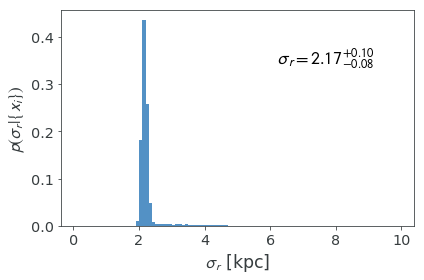

In [47]:
# Now plot the posterior:
plot_posterior(chain_file='/Users/athoag/Dropbox/Research/Papers/lya_offsets/mcmc/mcmc_chain_nwalkers100_nsteps250.txt')

OK, so this is reassuring that I have the MCMC set up right and that the likelihood is not crazy. The next step is to incorporate measurement error as well. A test I should do is use only a fraction of the dataset and see if the posterior constraint gets worse.

## Incorporating measurement error
Let's rewrite the likelihood including a measurement error term.
Let:
$$ \sigma_x^{\prime 2} = \sigma_{x,\mathrm{msr}}^2 + \sigma_{x,\mathrm{Ly}\alpha}^2$$
$$ \sigma_y^{\prime 2} = \sigma_x^{\prime 2}$$
We have the same form for $dp(x,y)$ as before, just substitute $\sigma_x$ for $\sigma_x^{\prime}$:

$$ dp(x,y) = \frac{1}{2\pi \sigma_x^{\prime 2}} \exp\left(-\frac{1}{2\sigma_x^{\prime 2}}(x^2 + y^2)\right)dxdy $$

And as before we can substitute for the radial standard deviation:
$$ \sigma_r^{\prime 2} = 2 \sigma_x^{\prime 2}, $$
$$ \sigma_r^{\prime 2} = \sigma_{r,\mathrm{msr}}^2 + \sigma_{r,\mathrm{Ly}\alpha}^2, $$
where $\sigma_{r,\mathrm{msr}}$ is the measurement error we will assume and $\sigma_{r,\mathrm{Ly}\alpha}$ is what we are trying to constrain.
$$ dp(x,y) = \frac{1}{\pi \sigma_r^{\prime 2}} \exp\left(-\frac{1}{\sigma_r^{\prime 2}}(x^2 + y^2)\right)dxdy $$

As before we integrate over y to get $dp(x)/dx$:
$$ \frac{dp(x|\sigma_r^{\prime})}{dx} = \int{dy \frac{1}{\pi \sigma_r^{\prime 2}} \exp\left(\frac{-1}{\sigma_r^{\prime 2}}(x^2+y^2)\right)} = \frac{1}{\pi \sigma_r^{\prime 2}} \exp\left(-\frac{x^2}{\sigma_r^{\prime 2}} \right) \int_{y=-\infty}^{y=+\infty}{dy \exp\left(-\frac{y^2}{\sigma_r^{\prime 2}}\right)} = \frac{1}{\pi \sigma_r^{\prime 2}} \exp\left(-\frac{x^2}{\sigma_r^{\prime 2}} \right) [\sqrt{\pi} \sigma_r^{\prime} ] $$ 
So our final form for the likelihood in this case is:
$$ \frac{dp(x|\sigma_{r,\mathrm{msr}},\sigma_{\mathrm{Ly}\alpha})}{dx} = \frac{1}{\sqrt{\pi(\sigma_{r,\mathrm{msr}}^2 + \sigma_{r,\mathrm{Ly}\alpha}^2)} } \exp\left(-\frac{x^2}{\sigma_{r,\mathrm{msr}}^2 + \sigma_{r,\mathrm{Ly}\alpha}^2}\right) $$
which is again just a Gaussian with a modified $\sigma$: $N(0,\sigma=\sigma_r^{\prime}/\sqrt{2})$

## Implementation with measurement error

In [66]:
def llh_msr_err(sigma_r_msr,sigma_lya_kpc,x):
    ''' 
    ---PURPOSE---
    Evaulate a likelihood p(x|sigma_r_kpc)
    at a particular value of x
    --INPUT---
    sigma_r_msr     The width of the measurement error gaussian
    sigma_r_kpc     The width of gaussian distribution of 
                    Lya offsets
    x               The value of the offset in kpc 
                    at which you want to evaluate the likelihood
    --OUTPUT--
    '''
    llh = 1/np.sqrt(np.pi*(sigma_r_msr**2+sigma_lya_kpc**2))*\
        np.exp(-(x**2/(sigma_r_msr**2+sigma_lya_kpc**2)))
    return llh

def lnlike_4mcmc_msr_err(sigma_lya_kpc, offsets_kpc, sigmas_r_msr,):
    ''' 
    ---PURPOSE---
    Calculate the summed log-likelihood  
    for all offsets
    ---INPUT---
    sigma_r_kpc     The width of gaussian distribution of radial offsets
                    of our particular model
    x               The value of the offset in kpc 
                    at which you want to evaluate the likelihood
    --OUTPUT--
    '''
    likelihoods = np.array([llh_msr_err(sigma_r_msr=sigmas_r_msr[ii],sigma_lya_kpc=sigma_lya_kpc,
        x=offsets_kpc[ii]) for ii in range(len(offsets_kpc))])
    return np.sum(np.log(likelihoods))
    
def lnprior_4mcmc_msr_err(sigma_lya_kpc):
    ''' 
    ---PURPOSE---
    Define the prior on the model parameter,
    i.e. the sigma of the radial offset distribution in kpc
    which will be used by the emcee sampler.
    Flat prior between 0.1 and 10 kpc
    ---INPUT---
    sigma_lya_kpc   The width of the lya offset distribution 
    --OUTPUT--
    '''
    if 0.1<sigma_lya_kpc<10.:
        return 0.0
    return -np.inf

def lnprob_4mcmc_msr_err(sigma_lya_kpc, offsets_kpc, sigmas_r_msr):
    ''' 
    ---PURPOSE---
    Calculate the log posterior 
    by summing the log llh and the log prior
    i.e. the sigma of the radial offset distribution in kpc
    which will be used by the emcee sampler.
    Flat prior between 0.1 and 10 kpc
    ---INPUT---
    sigma_lya_kpc   The width of the lya offset distribution 
    offsets_kpc     The measured offsets from our data in kpc
    --OUTPUT--
    '''
    lp = lnprior_4mcmc_msr_err(sigma_lya_kpc=sigma_lya_kpc)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_4mcmc_msr_err(sigma_lya_kpc, offsets_kpc, sigmas_r_msr)

def run_mcmc_msr_err(uncertainty_pixel=1,nwalkers=100,nsteps=250,verbose=True,savechain=True):
    """
    ---- PURPOSE ----
    Run the MCMC sampler and return the MCMC chain 
    from comparing the measured spatial offsets with 
    the model
    ---- INPUT ----
    uncertainty_pixel       The uncertainty in the spatial centroid in pixels (must assume)
    nwalkers                The number of paths throught the parameter space that are taken. 
                            100 or greater is good
    nsteps                  The number of steps to take in each walker chain.
                            500 recommended on emcee website
    verbose                 If True, will print status updates about run to the screen 
    savechain               If True, will save the mcmc chain to a text file
    ---- OUTPUT ----
    sampler         An object containing information about the mcmc run, including the chain 
    """
    ''' Set up the data '''
    offset_tab = Table.read(offset_cat_gauss,format='ascii.commented_header')
    print "Have %i objects in the original offset table before cleaning" % len(offset_tab)
    ''' Load in the good specfiles from my visual inspection '''
    good_specfiles_tab = Table.read(good_specfiles_file,format='ascii.commented_header')
    good_specfiles = good_specfiles_tab['specfile']
    bad_indices = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] not in good_specfiles]
    offset_tab.remove_rows(bad_indices)
    ''' Now remove the specfiles which I identified as having bad optimized lya positions '''
    bad_specfiles_tab = Table.read(bad_specfiles_file,format='ascii.commented_header')
    bad_specfiles = bad_specfiles_tab['specfile']
    bad_indices2 = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] in bad_specfiles]
    offset_tab.remove_rows(bad_indices2)
    print "Have %i objects in the offset table after cleaning" % len(offset_tab)

    zs_lya = offset_tab['z_lya']
    y_lya_priors = offset_tab['y_lya_prior']
    y_lya_opts = offset_tab['y_lya_opt']
    
    offsets_pix = y_lya_priors - y_lya_opts
    offsets_arcsec = offsets_pix*pixscale_vimos_spatial
    arcsecs_per_kpc = np.array([cosmo.arcsec_per_kpc_proper(z_lya).value for z_lya in zs_lya])

    offsets_kpc = np.array([offsets_arcsec[ii]/arcsecs_per_kpc[ii] for ii in range(len(offsets_arcsec))])
    # uncertainty_pixel = 1 # measurement uncertainty in spatial centroiding in pixels
    uncertainty_arcsec = uncertainty_pixel*pixscale_vimos_spatial # measurement uncertainty in spatial centroiding in arcsec
    msr_errors_kpc = np.array([np.sqrt(2)*uncertainty_arcsec/arcsecs_per_kpc[ii] \
                for ii in range(len(offsets_arcsec))])

    ''' set up the mcmc parameters '''
    sigma_r_min = 0.1
    sigma_r_max = 5.
  
    ''' Now set up the sampler '''
    ndim = 1
    ''' initialize a Gaussian around the mean of the parameter range  '''
    pos = [np.array([np.mean([sigma_r_min,sigma_r_max])]) + 1e-2*np.random.randn(ndim) \
                for i in range(nwalkers)] 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_4mcmc_msr_err, args=(offsets_kpc,msr_errors_kpc))
    print "Optimizing for sigma_r_kpc"

    print "running sampler for %i steps with %i walkers" % (nsteps,nwalkers)

    if verbose:
        for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
            print("{0:5.1%}".format(float(i) / nsteps))
    else:
        sampler.run_mcmc(pos,nsteps)

    if savechain:
        savename = mcmc_dir + '/mcmc_chain_nwalkers%i_nsteps%i_msr_err_%.1fpix.txt' % (nwalkers,nsteps,uncertainty_pixel)
        print "saving %s" % savename
        np.savetxt(savename,sampler.flatchain)

    return sampler


In [49]:
run_mcmc_msr_err(nwalkers=100,nsteps=250,uncertainty_pixel=1.)

Have 1248 objects in the original offset table before cleaning
Have 415 objects in the offset table after cleaning
Optimizing for sigma_r_kpc
running sampler for 250 steps with 100 walkers
 0.0%
 0.4%
 0.8%
 1.2%
 1.6%
 2.0%
 2.4%
 2.8%
 3.2%
 3.6%
 4.0%
 4.4%
 4.8%
 5.2%
 5.6%
 6.0%
 6.4%
 6.8%
 7.2%
 7.6%
 8.0%
 8.4%
 8.8%
 9.2%
 9.6%
10.0%
10.4%
10.8%
11.2%
11.6%
12.0%
12.4%
12.8%
13.2%
13.6%
14.0%
14.4%
14.8%
15.2%
15.6%
16.0%
16.4%
16.8%
17.2%
17.6%
18.0%
18.4%
18.8%
19.2%
19.6%
20.0%
20.4%
20.8%
21.2%
21.6%
22.0%
22.4%
22.8%
23.2%
23.6%
24.0%
24.4%
24.8%
25.2%
25.6%
26.0%
26.4%
26.8%
27.2%
27.6%
28.0%
28.4%
28.8%
29.2%
29.6%
30.0%
30.4%
30.8%
31.2%
31.6%
32.0%
32.4%
32.8%
33.2%
33.6%
34.0%
34.4%
34.8%
35.2%
35.6%
36.0%
36.4%
36.8%
37.2%
37.6%
38.0%
38.4%
38.8%
39.2%
39.6%
40.0%
40.4%
40.8%
41.2%
41.6%
42.0%
42.4%
42.8%
43.2%
43.6%
44.0%
44.4%
44.8%
45.2%
45.6%
46.0%
46.4%
46.8%
47.2%
47.6%
48.0%
48.4%
48.8%
49.2%
49.6%
50.0%
50.4%
50.8%
51.2%
51.6%
52.0%
52.4%
52.8%
53.2%
53.6%
5

In [77]:
def plot_posterior_msr_err(chain_file,show=True,save=False):
    """
    ---- PURPOSE ----
    Plot the posterior of sigma_r_kpc from the output of the mcmc chain
    ---- INPUT ----
    chain_file      The txt file saved in run_mcmc_1D() that has the chain information
    ---- OUTPUT ----
    matplotlib file
    """
    tab = Table.read(chain_file,format='ascii.no_header',names=['sigma_r_kpc'])
    sigma_r_kpc_all = tab['sigma_r_kpc']
    ''' need to remove burn-in steps, so first ~30 steps.
    Since the array is flattened along the walker axis,
    the rows in sigma_r_kpc_all for the first 30/nsteps repeating are the burnt-in ones.    '''
    
    samples_flat,nwalkers,nsteps = read_chainfile(chain_file)
    uncertainty_pixel = float(chain_file.split('/')[-1].split('_')[-1].rstrip('pix.txt'))
    non_burn_in_mask = np.array([x+np.arange(30,nsteps) for x in range(0,len(sigma_r_kpc_all),nsteps)])
    sigma_r_kpc_noburnin = sigma_r_kpc_all[non_burn_in_mask].flatten()
    med,low,high = confidence_interval(sigma_r_kpc_noburnin)
    higherr = high-med
    lowerr = med-low
    
    if show:
        plt.ion()
    else:
        plt.ioff()
    
    fig=plt.figure()
    ax = fig.add_subplot(1,1,1)
    sigma_r_min = 0.1
    sigma_r_max = 10.
    delta_sigma_r = 0.1
    weights = np.ones_like(sigma_r_kpc_noburnin)/float(len(sigma_r_kpc_noburnin))
    bins=np.arange(sigma_r_min, sigma_r_max, delta_sigma_r)
    posterior,bin_edges,_=ax.hist(sigma_r_kpc_noburnin, weights=weights,bins=bins,alpha=0.75)
    bin_cens = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
    ax.set_xlabel(r'$\sigma_{r,\mathrm{Ly}\alpha}$ [kpc]')
    ax.set_ylabel(r'$p(\sigma_{r,\mathrm{Ly}\alpha}|\{x_i\})$ ')
    ax.annotate('Assuming\n' +  r'$\sigma_{x,\mathrm{msr}} = %.1f$ pix' % uncertainty_pixel,
        color='k', xy=(0.5,0.75), xycoords='axes fraction',fontsize=18,horizontalalignment='center',)
    
    ax.annotate(r'$\sigma_{r,\mathrm{Ly}\alpha} = %.2f^{+%.2f}_{-%.2f}$' % (med,higherr,lowerr), 
        color='k', xy=(0.5,0.5),xycoords='axes fraction',fontsize=18,horizontalalignment='center',)
    plt.tight_layout()
    if save:
        savename = mcmc_dir + '/posterior_msr_err_%.1fpix.png' % uncertainty_pixel
        plt.savefig(savename,format='png')
        print "Saved %s" % savename

mcmc_chain_nwalkers100_nsteps250_msr_err_1pix.txt


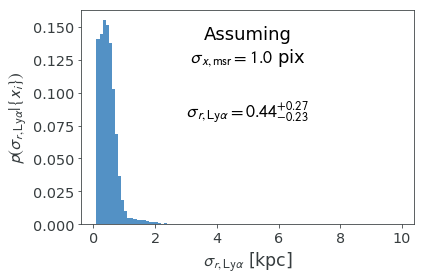

In [78]:
plot_posterior_msr_err('/Users/athoag/Dropbox/Research/Papers/lya_offsets/mcmc/mcmc_chain_nwalkers100_nsteps250_msr_err_1pix.txt')

So this is the constraint on the actual width of the Lyman-alpha spatial offset radial distribution, assuming that gets convolved with a Gaussian representing the measurement error. Here I assumed that the measurement error on the spatial offset was 1 pixel. This is probably an overestimate. If I drop that to 0.5 pixels this is what I would get:

In [67]:
run_mcmc_msr_err(uncertainty_pixel=0.5)

Have 1248 objects in the original offset table before cleaning
Have 415 objects in the offset table after cleaning
Optimizing for sigma_r_kpc
running sampler for 250 steps with 100 walkers
 0.0%
 0.4%
 0.8%
 1.2%
 1.6%
 2.0%
 2.4%
 2.8%
 3.2%
 3.6%
 4.0%
 4.4%
 4.8%
 5.2%
 5.6%
 6.0%
 6.4%
 6.8%
 7.2%
 7.6%
 8.0%
 8.4%
 8.8%
 9.2%
 9.6%
10.0%
10.4%
10.8%
11.2%
11.6%
12.0%
12.4%
12.8%
13.2%
13.6%
14.0%
14.4%
14.8%
15.2%
15.6%
16.0%
16.4%
16.8%
17.2%
17.6%
18.0%
18.4%
18.8%
19.2%
19.6%
20.0%
20.4%
20.8%
21.2%
21.6%
22.0%
22.4%
22.8%
23.2%
23.6%
24.0%
24.4%
24.8%
25.2%
25.6%
26.0%
26.4%
26.8%
27.2%
27.6%
28.0%
28.4%
28.8%
29.2%
29.6%
30.0%
30.4%
30.8%
31.2%
31.6%
32.0%
32.4%
32.8%
33.2%
33.6%
34.0%
34.4%
34.8%
35.2%
35.6%
36.0%
36.4%
36.8%
37.2%
37.6%
38.0%
38.4%
38.8%
39.2%
39.6%
40.0%
40.4%
40.8%
41.2%
41.6%
42.0%
42.4%
42.8%
43.2%
43.6%
44.0%
44.4%
44.8%
45.2%
45.6%
46.0%
46.4%
46.8%
47.2%
47.6%
48.0%
48.4%
48.8%
49.2%
49.6%
50.0%
50.4%
50.8%
51.2%
51.6%
52.0%
52.4%
52.8%
53.2%
53.6%
5

mcmc_chain_nwalkers100_nsteps250_msr_err_0.5pix.txt


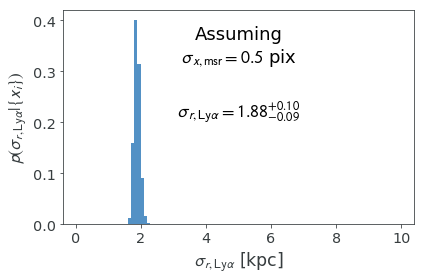

In [79]:
plot_posterior_msr_err('/Users/athoag/Dropbox/Research/Papers/lya_offsets/mcmc/mcmc_chain_nwalkers100_nsteps250_msr_err_0.5pix.txt')

So we can see that if we make the measurement uncertainty smaller, than the underlying offset distribution is larger, and more tightly constrained. There is a perfect degeneracy here, so we will want to know our measurement uncertainty very well. Can do a simulation to constrain it. Hopefully it is small! 

So with these parameters we can only place an upper limit on the size of the Lya offset distribution, assuming it is a 2D Gaussian. Let's see how the value of the seeing affects the inference. If we decrease it to 0.5" do we do better?

## Next steps
1. Estimating the measurement uncertainty on the spatial offset -- right now I am just putting in a guess (1/2 pixel), but this needs to be known well if we want to constrain the underlying lya offset distribution. I plan to estimate the measurement uncertainty via simulations. Note that if I include seeing in these simulations then don't include it as an extra term in the likelihood.
2.  Regarding seeing, I assumed that seeing was the same for all observations (I tried a few different values). We don't have the actual seeing info, but Laura said she would look into how to calculate it for each mask from point sources. I will check in with her to see how this is going. Will need this for the measurement uncertainty simulations. 
3. Slit-losses. The likelihood should take into account the width of the slit. This is true because if an offset has a large y-componenet then it will be unlikely that any flux will land in the slit. The dependence on slit width should show up when integrating over $y$ to get $dp/dx$

## 1. Estimating measurement uncertainty on spatial offset
Can simulate the measurement uncertainty, $\sigma_{x,\mathrm{msr}}$ as a function of Lyman-alpha SNR and FWHM of the seeing, two parameters which should affect the uncertainty in different ways. 

Did a simulation with:
run_uncertainty_simulations() 
in model_offset.py 

The code is a bit too long to include in this notebook, but the idea is to generate Lyman-alpha emission lines for a range of FWHM seeing and Lyman-alpha SNR and then try to recover the centroid. I then keep track of the spatial offset and then calculate the standard deviation of the offset in 2d bins. The offset as a function of these two parameters looks like:

In [114]:
catalog_simdir = paper_dir + '/catalogs_sim'
offset_sim_cat = catalog_simdir + '/offset_recovery_simulation_latest.txt'
from scipy.optimize import curve_fit
import zscale

def plot_uncertainty_2d(plot=True,save=False):
    ''' 
    ---PURPOSE---
    Plot the relationship between offset uncertainty, 
    seeing FWHM (on the horizontal axis) and Lya S/N
    as the third dimension
    ---INPUT---
    --OUTPUT--
    '''
    
    ''' First let's visualize the data '''
    offset_sim_tab = Table.read(offset_sim_cat,format='ascii.commented_header')
    # fwhm_seeing_arcsec y_lya_prior y_lya_opt snr_lya_int
    y_lya_opt = offset_sim_tab['y_lya_opt']
    finite_mask = y_lya_opt > -99
    offset_sim_tab = offset_sim_tab[finite_mask]
    seeing = offset_sim_tab['fwhm_seeing_arcsec']
    snr_lya_int = offset_sim_tab['snr_lya_int']
    y_lya_prior = offset_sim_tab['y_lya_prior']
    y_lya_opt = offset_sim_tab['y_lya_opt']

    offset = y_lya_prior-y_lya_opt # spatial offset in pixels

    ''' At fixed Lya S/N, let's see how the standard deviation of offsets increases 
    with seeing '''
    seeing_grid = sorted(set(seeing))
    snr_bins = range(1,21,2)
    snr_bin_cens = [(snr_bins[i]+snr_bins[i+1])/2. for i in range(len(snr_bins)-1)]
    uncertainty_array = np.zeros([len(seeing_grid),len(snr_bin_cens)]) # len(FWHM)xlen(snr_bin_cens)
    
    for ii in range(len(snr_bins)-1):
        snr_left = snr_bins[ii]
        snr_right = snr_bins[ii+1]
        mask_left = snr_lya_int>=snr_left
        mask_right = snr_lya_int<snr_right
        snr_bin_mask = (mask_left) & (mask_right)
        seeing_snr_bin = seeing[snr_bin_mask]
        offsets_snr_bin = offset[snr_bin_mask]
        # stddevs_this_snr = [] # will be size of seeing_grid
        for jj,seeing_val in enumerate(seeing_grid):

            ''' calculate stddev of offset for each seeing value '''
            seeing_mask = seeing_snr_bin == seeing_val
            offsets_thisseeing = offsets_snr_bin[seeing_mask]
            stddev_offsets_binned = np.std(offsets_thisseeing)
            # stddevs_this_snr.append(stddev_offsets_binned)
            uncertainty_array[jj][ii] = stddev_offsets_binned


    if plot:
        plt.ion()
        # plt.close("all")
        vmin=0
        vmax=3
        fig, ax = plt.subplots(1,1)
        # data 

        im_data=ax.imshow(uncertainty_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        cbar = fig.colorbar(im_data)
        cbar.set_label(r'Centroid uncertainty (pix)',fontsize=16)
        ax.set_xlabel('SNR',fontsize=16)
        ax.set_ylabel('Seeing FWHM (")',fontsize=16)

        plt.tight_layout()
        if save:
            savename = plot_dir + '/uncertainty_2d_plot.png'
            plt.savefig(savename,format='png')
            print "Saved %s" % savename

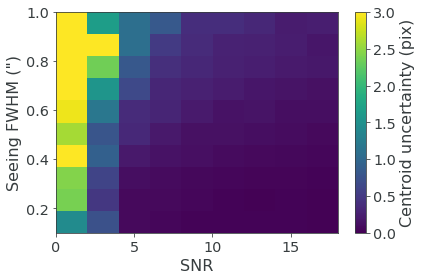

In [115]:
plot_uncertainty_2d()

So this is what we would expect: as FWHM increases, the centroid uncertainty increases rapidly. As the SNR increases, centroid uncertainty decreases. At SNR>~10, the centroid uncertainty essentially hits a floor.

Let's try to fit a function to this. Let's try 3 different functions:
1. $\sigma_x(m,c) = m\left(\frac{\mathrm{FWHM}}{\sqrt{S/N}}\right) + c$
2. $\sigma_x(m,c) = m\left(\frac{\mathrm{FWHM}}{e^{S/N}}\right) + c$
3. $\sigma_x(m,\alpha,c) = m\left(\frac{\mathrm{FWHM}}{{S/N}^\alpha}\right) + c$

In [116]:
# Implementation of the 3 functions above
def fit_func1(X,m,c):
    '''
    The function we will try to fit our 
    2D measurement uncertainty data to.
    Linear in fwhm, (-1/2) power law in SNR
    ---INPUT--
    X               A tuple (x1,x2) of features
                    that must both have the same shape
                    as the 2D data array
                    Can use meshgrid to achieve this
    m               The slope of the FWHM relation
    c               The intercept 
    --OUTPUT---
    func2d.ravel()  The raveled evaluation of the function
    '''
    snrs2D,seeing_fwhm2D = X

    func2d = m*seeing_fwhm2D/np.sqrt(snrs2D)+c
    return func2d.ravel()

def fit_func2(X,m,c):
    '''
    The function we will try to fit our 
    2D measurement uncertainty data to.
    Linear in fwhm, e^{-x} in SNR
    ---INPUT--
    X               A tuple (x1,x2) of features
                    that must both have the same shape
                    as the 2D data array
                    Can use meshgrid to achieve this
    m               The slope of the FWHM relation
    c               The intercept 
    --OUTPUT---
    func2d.ravel()  The raveled evaluation of the function
    '''
    snrs2D,seeing_fwhm2D = X

    func2d = m*seeing_fwhm2D*np.exp(-snrs2D)+c
    return func2d.ravel()

def fit_func3(X,m,alpha,c):
    '''
    The function we will try to fit our 
    2D measurement uncertainty data to.
    Linear in fwhm, generic power law in SNR
    ---INPUT--
    X               A tuple (x1,x2) of features
                    that must both have the same shape
                    as the 2D data array
                    Can use meshgrid to achieve this
    m               The slope of the FWHM relation
    alpha           The power law of SNR
    c               The intercept 
    --OUTPUT---
    func2d.ravel()  The raveled evaluation of the function
    '''
    snrs2D,seeing_fwhm2D = X

    func2d = m*seeing_fwhm2D/(snrs2D**alpha)+c
    return func2d.ravel()

In [140]:


def fit_uncertainty_2d_model1(plot=True,save=False):
    ''' 
    ---PURPOSE---
    Plot the relationship between offset uncertainty, 
    seeing FWHM (on the horizontal axis) and Lya S/N
    as the third dimension.
    And then try to fit this function with a simple model 
    given by fit_func1()
    ---INPUT---
    --OUTPUT--
    '''
    
    ''' First let's visualize the data '''
    offset_sim_tab = Table.read(offset_sim_cat,format='ascii.commented_header')
    # fwhm_seeing_arcsec y_lya_prior y_lya_opt snr_lya_int
    y_lya_opt = offset_sim_tab['y_lya_opt']
    finite_mask = y_lya_opt > -99
    offset_sim_tab = offset_sim_tab[finite_mask]
    seeing = offset_sim_tab['fwhm_seeing_arcsec']
    snr_lya_int = offset_sim_tab['snr_lya_int']
    y_lya_prior = offset_sim_tab['y_lya_prior']
    y_lya_opt = offset_sim_tab['y_lya_opt']

    offset = y_lya_prior-y_lya_opt # spatial offset in pixels

    ''' At fixed Lya S/N, let's see how the standard deviation of offsets increases 
    with seeing '''
    seeing_grid = sorted(set(seeing))
    snr_bins = range(1,21,2)
    snr_bin_cens = [(snr_bins[i]+snr_bins[i+1])/2. for i in range(len(snr_bins)-1)]
    uncertainty_array = np.zeros([len(seeing_grid),len(snr_bin_cens)]) # len(FWHM)xlen(snr_bin_cens)

    for ii in range(len(snr_bins)-1):
        snr_left = snr_bins[ii]
        snr_right = snr_bins[ii+1]
        mask_left = snr_lya_int>=snr_left
        mask_right = snr_lya_int<snr_right
        snr_bin_mask = (mask_left) & (mask_right)
        seeing_snr_bin = seeing[snr_bin_mask]
        offsets_snr_bin = offset[snr_bin_mask]
        # stddevs_this_snr = [] # will be size of seeing_grid
        for jj,seeing_val in enumerate(seeing_grid):

            ''' calculate stddev of offset for each seeing value '''
            seeing_mask = seeing_snr_bin == seeing_val
            offsets_thisseeing = offsets_snr_bin[seeing_mask]
            stddev_offsets_binned = np.std(offsets_thisseeing)
            # stddevs_this_snr.append(stddev_offsets_binned)
            uncertainty_array[jj][ii] = stddev_offsets_binned


    # initial guesses for m,c:
    m_init = 0.5
    # alpha_init = -0.5
    c_init = 0.

    # p0 = m_init,alpha_init,c_init
    p0 = m_init,c_init
    X = np.meshgrid(np.array(snr_bin_cens),np.array(seeing_grid))

    popt, pcov = curve_fit(fit_func1,X,uncertainty_array.ravel(),p0)
    print "Optimized parameters are m=%.2f, c=%.2f" % (popt[0],popt[1])
    # print "Optimized parameters are m=%.2f,c=%.2f" % (popt[0],popt[1],popt[2])
    model_array = fit_func1(X,*popt).reshape(uncertainty_array.shape) # puts it back in same 2D dimesions as uncertainty_array
    resid_array = (uncertainty_array-model_array)

    if plot:
        plt.ion()
        # plt.close("all")
        vmin,vmax = zscale.zscale(uncertainty_array)
        vmin=-0.5
#         print vmin,vmax
        # vmin=-1
        # vmax=4
        fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(14,6))
        # data 
        ax_data = axes[0]
        im_data=ax_data.imshow(uncertainty_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_data.set_title('sim. data')
        snr_ticks = np.linspace(min(snr_bin_cens),max(snr_bin_cens),5)
        ax_data.set_xticks(snr_ticks)
        # model
        ax_model = axes[1]
        ax_model.imshow(model_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_model.set_title(r'$\sigma_x(m,c) = m\left(\frac{\mathrm{FWHM}}{\sqrt{S/N}}\right) + c$ ' \
            + '\n' + r'$m_{\mathrm{opt}}=%.1f, c_{\mathrm{opt}} =%.1f$' % (popt[0],popt[1]),fontsize=16)
        # residual
        ax_resid = axes[2]
        ax_resid.imshow(resid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_resid.set_title('data-model')
        fig.subplots_adjust(bottom=0.25)
        cbar_data_ax = fig.add_axes([0.1, 0.1, 0.6, 0.05])
        cbar_data = fig.colorbar(im_data, cax=cbar_data_ax,orientation='horizontal')
        cbar_data.set_label(r'Measurement uncertainty (pix)',fontsize=16)
        cbar_data.ax.tick_params(labelsize=14)
        # fractional residual
        ax_fracresid = axes[3]
        fracresid_array = resid_array/uncertainty_array
        im_fracresid=ax_fracresid.imshow(fracresid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=-1.,vmax=1.,cmap='gray_r')
        ax_fracresid.set_title('(data-model)/data')
        cbar_fracresid_ax = fig.add_axes([0.72, 0.1, 0.19, 0.05])
        cbar_fracresid = fig.colorbar(im_fracresid, cax=cbar_fracresid_ax,
            ticks=[-1, 0, 1], orientation='horizontal')
        cbar_fracresid.set_label(r'Fractional residual',fontsize=16)
        cbar_fracresid.ax.tick_params(labelsize=14) 
        # labels
        ax_model.set_xlabel('SNR',fontsize=16)
        ax_data.set_ylabel('Seeing FWHM (")',fontsize=16)

        if save:
            savename = plot_dir + '/fit_uncertainty_2d_model1.png'
            plt.savefig(savename,format='png')
            print "Saved %s" % savename


def fit_uncertainty_2d_model2(plot=True,save=False):
    ''' 
    ---PURPOSE---
    Plot the relationship between offset uncertainty, 
    seeing FWHM (on the horizontal axis) and Lya S/N
    as the third dimension.
    And then try to fit this function with a simple model 
    given by fit_func2()
    ---INPUT---
    --OUTPUT--
    '''
    
    ''' First let's visualize the data '''
    offset_sim_tab = Table.read(offset_sim_cat,format='ascii.commented_header')
    # fwhm_seeing_arcsec y_lya_prior y_lya_opt snr_lya_int
    y_lya_opt = offset_sim_tab['y_lya_opt']
    finite_mask = y_lya_opt > -99
    offset_sim_tab = offset_sim_tab[finite_mask]
    seeing = offset_sim_tab['fwhm_seeing_arcsec']
    snr_lya_int = offset_sim_tab['snr_lya_int']
    y_lya_prior = offset_sim_tab['y_lya_prior']
    y_lya_opt = offset_sim_tab['y_lya_opt']

    offset = y_lya_prior-y_lya_opt # spatial offset in pixels

    ''' At fixed Lya S/N, let's see how the standard deviation of offsets increases 
    with seeing '''
    seeing_grid = sorted(set(seeing))
    snr_bins = range(1,21,2)
    snr_bin_cens = [(snr_bins[i]+snr_bins[i+1])/2. for i in range(len(snr_bins)-1)]
    uncertainty_array = np.zeros([len(seeing_grid),len(snr_bin_cens)]) # len(FWHM)xlen(snr_bin_cens)

    for ii in range(len(snr_bins)-1):
        snr_left = snr_bins[ii]
        snr_right = snr_bins[ii+1]
        mask_left = snr_lya_int>=snr_left
        mask_right = snr_lya_int<snr_right
        snr_bin_mask = (mask_left) & (mask_right)
        seeing_snr_bin = seeing[snr_bin_mask]
        offsets_snr_bin = offset[snr_bin_mask]
        # stddevs_this_snr = [] # will be size of seeing_grid
        for jj,seeing_val in enumerate(seeing_grid):

            ''' calculate stddev of offset for each seeing value '''
            seeing_mask = seeing_snr_bin == seeing_val
            offsets_thisseeing = offsets_snr_bin[seeing_mask]
            stddev_offsets_binned = np.std(offsets_thisseeing)
            # stddevs_this_snr.append(stddev_offsets_binned)
            uncertainty_array[jj][ii] = stddev_offsets_binned

    # initial guesses for m,c:
    m_init = 0.5
    # alpha_init = -0.5
    c_init = 0.

    # p0 = m_init,alpha_init,c_init
    p0 = m_init,c_init
    X = np.meshgrid(np.array(snr_bin_cens),np.array(seeing_grid))

    popt, pcov = curve_fit(fit_func2,X,uncertainty_array.ravel(),p0)
    print "Optimized parameters are m=%.2f, c=%.2f" % (popt[0],popt[1])
    # print "Optimized parameters are m=%.2f,c=%.2f" % (popt[0],popt[1],popt[2])
    model_array = fit_func2(X,*popt).reshape(uncertainty_array.shape) # puts it back in same 2D dimesions as uncertainty_array
    resid_array = (uncertainty_array-model_array)

    if plot:
        plt.ion()
        # plt.close("all")
        vmin,vmax = zscale.zscale(uncertainty_array)
        vmin=-0.5
#         print vmin,vmax
        # vmin=-1
        # vmax=4
        fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(14,6))
        # data 
        ax_data = axes[0]
        im_data=ax_data.imshow(uncertainty_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_data.set_title('sim. data')
        snr_ticks = np.linspace(min(snr_bin_cens),max(snr_bin_cens),5)
        ax_data.set_xticks(snr_ticks)
        # model
        ax_model = axes[1]
        ax_model.imshow(model_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        # ax_model.set_title('model\n' + r'$\sigma_x(m,\alpha,c) = m\left(\frac{\mathrm{FWHM}}{{S/N}^\alpha}\right) + c$ ' \
        #   + '\n' + r'$m_{\mathrm{opt}}=%.1f, \alpha_{\mathrm{opt}}=%.1f, c_{\mathrm{opt}} =%.1f$' % (popt[0],popt[1],popt[2]),fontsize=12)
        ax_model.set_title(r'$\sigma_x(m,c) = m\left(\frac{\mathrm{FWHM}}{e^{S/N}}\right) + c$ ' \
            + '\n' + r'$m_{\mathrm{opt}}=%.1f, c_{\mathrm{opt}} =%.1f$' % (popt[0],popt[1]),fontsize=16)
        # residual
        ax_resid = axes[2]
        ax_resid.imshow(resid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_resid.set_title('data-model')
        
        fig.subplots_adjust(bottom=0.25)
        cbar_data_ax = fig.add_axes([0.1, 0.1, 0.6, 0.05])
        cbar_data = fig.colorbar(im_data, cax=cbar_data_ax,orientation='horizontal')
        cbar_data.set_label(r'Measurement uncertainty (pix)',fontsize=16)
        cbar_data.ax.tick_params(labelsize=14)
        # fractional residual
        ax_fracresid = axes[3]
        fracresid_array = resid_array/uncertainty_array
        im_fracresid=ax_fracresid.imshow(fracresid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=-1.,vmax=1.,cmap='gray_r')
        ax_fracresid.set_title('(data-model)/data')
        cbar_fracresid_ax = fig.add_axes([0.72, 0.1, 0.19, 0.05])
        cbar_fracresid = fig.colorbar(im_fracresid, cax=cbar_fracresid_ax,
            ticks=[-1, 0, 1], orientation='horizontal')
        cbar_fracresid.set_label(r'Fractional residual',fontsize=16)
        cbar_fracresid.ax.tick_params(labelsize=14) 
        # labels
        ax_model.set_xlabel('SNR',fontsize=16)
        ax_data.set_ylabel('Seeing FWHM (")',fontsize=16)

        # plt.tight_layout()
        if save:
            savename = plot_dir + '/fit_uncertainty_2d_model2.png'
            plt.savefig(savename,format='png')
            print "Saved %s" % savename

def fit_uncertainty_2d_model3(plot=True,save=False):
    ''' 
    ---PURPOSE---
    Plot the relationship between offset uncertainty, 
    seeing FWHM (on the horizontal axis) and Lya S/N
    as the third dimension.
    And then try to fit this function with a simple model 
    given by fit_func2()
    ---INPUT---
    --OUTPUT--
    '''
    
    ''' First let's visualize the data '''
    offset_sim_tab = Table.read(offset_sim_cat,format='ascii.commented_header')
    # fwhm_seeing_arcsec y_lya_prior y_lya_opt snr_lya_int
    y_lya_opt = offset_sim_tab['y_lya_opt']
    finite_mask = y_lya_opt > -99
    offset_sim_tab = offset_sim_tab[finite_mask]
    seeing = offset_sim_tab['fwhm_seeing_arcsec']
    snr_lya_int = offset_sim_tab['snr_lya_int']
    y_lya_prior = offset_sim_tab['y_lya_prior']
    y_lya_opt = offset_sim_tab['y_lya_opt']

    offset = y_lya_prior-y_lya_opt # spatial offset in pixels

    ''' At fixed Lya S/N, let's see how the standard deviation of offsets increases 
    with seeing '''
    seeing_grid = sorted(set(seeing))
    snr_bins = range(1,21,2)
    snr_bin_cens = [(snr_bins[i]+snr_bins[i+1])/2. for i in range(len(snr_bins)-1)]
    uncertainty_array = np.zeros([len(seeing_grid),len(snr_bin_cens)]) # len(FWHM)xlen(snr_bin_cens)

    for ii in range(len(snr_bins)-1):
        snr_left = snr_bins[ii]
        snr_right = snr_bins[ii+1]
        mask_left = snr_lya_int>=snr_left
        mask_right = snr_lya_int<snr_right
        snr_bin_mask = (mask_left) & (mask_right)
        seeing_snr_bin = seeing[snr_bin_mask]
        offsets_snr_bin = offset[snr_bin_mask]
        # stddevs_this_snr = [] # will be size of seeing_grid
        for jj,seeing_val in enumerate(seeing_grid):

            ''' calculate stddev of offset for each seeing value '''
            seeing_mask = seeing_snr_bin == seeing_val
            offsets_thisseeing = offsets_snr_bin[seeing_mask]
            stddev_offsets_binned = np.std(offsets_thisseeing)
            # stddevs_this_snr.append(stddev_offsets_binned)
            uncertainty_array[jj][ii] = stddev_offsets_binned


    # initial guesses for m,c:
    m_init = 0.5
    alpha_init = 0.5
    c_init = 0.

    p0 = m_init,alpha_init,c_init
    X = np.meshgrid(np.array(snr_bin_cens),np.array(seeing_grid))

    popt, pcov = curve_fit(fit_func3,X,uncertainty_array.ravel(),p0)
    # print "Optimized parameters are m=%.2f, c=%.2f" % (popt[0],popt[1])
    print "Optimized parameters are m=%.2f,alpha=%.2f,c=%.2f" % (popt[0],popt[1],popt[2])
    model_array = fit_func3(X,*popt).reshape(uncertainty_array.shape) # puts it back in same 2D dimesions as uncertainty_array
    resid_array = (uncertainty_array-model_array)

    if plot:
        plt.ion()
        # plt.close("all")
        vmin,vmax = zscale.zscale(uncertainty_array)
        vmin=-0.5
#         print vmin,vmax
        # vmin=-1
        # vmax=4
        fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(14,6))
        # data 
        ax_data = axes[0]
        im_data=ax_data.imshow(uncertainty_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_data.set_title('sim. data')
        snr_ticks = np.linspace(min(snr_bin_cens),max(snr_bin_cens),5)
        ax_data.set_xticks(snr_ticks)
        # model
        ax_model = axes[1]
        ax_model.imshow(model_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        # ax_model.set_title('model\n' + r'$\sigma_x(m,\alpha,c) = m\left(\frac{\mathrm{FWHM}}{{S/N}^\alpha}\right) + c$ ' \
        #   + '\n' + r'$m_{\mathrm{opt}}=%.1f, \alpha_{\mathrm{opt}}=%.1f, c_{\mathrm{opt}} =%.1f$' % (popt[0],popt[1],popt[2]),fontsize=12)
        ax_model.set_title(r'$\sigma_x(m,\alpha,c) = m\left(\frac{\mathrm{FWHM}}{{S/N}^\alpha}\right) + c$ ' \
            + '\n' + r'$m_{\mathrm{opt}}=%.1f, \alpha_{\mathrm{opt}}=%.1f, c_{\mathrm{opt}} =%.1f$' \
            % (popt[0],popt[1],popt[2]),fontsize=16)

        # residual
        ax_resid = axes[2]
        ax_resid.imshow(resid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=vmin,vmax=vmax)
        ax_resid.set_title('data-model')
        fig.subplots_adjust(bottom=0.25)
        cbar_data_ax = fig.add_axes([0.1, 0.1, 0.6, 0.05])
        cbar_data = fig.colorbar(im_data, cax=cbar_data_ax,orientation='horizontal')
        cbar_data.set_label(r'Measurement uncertainty (pix)',fontsize=16)
        cbar_data.ax.tick_params(labelsize=14)
        # fractional residual
        ax_fracresid = axes[3]
        fracresid_array = resid_array/uncertainty_array
        im_fracresid=ax_fracresid.imshow(fracresid_array,extent=(0,max(snr_bin_cens),min(seeing_grid),max(seeing_grid)),
            aspect='auto',vmin=-1.,vmax=1.,cmap='gray_r')
        ax_fracresid.set_title('(data-model)/data')
        cbar_fracresid_ax = fig.add_axes([0.72, 0.1, 0.19, 0.05])
        cbar_fracresid = fig.colorbar(im_fracresid, cax=cbar_fracresid_ax,
            ticks=[-1, 0, 1], orientation='horizontal')
        cbar_fracresid.set_label(r'Fractional residual',fontsize=16)
        cbar_fracresid.ax.tick_params(labelsize=14) 

        # labels
        ax_model.set_xlabel('SNR',fontsize=16)
        ax_data.set_ylabel('Seeing FWHM (")',fontsize=16)

        # plt.tight_layout()
        if save:
            savename = plot_dir + '/fit_uncertainty_2d_model3.png'
            plt.savefig(savename,format='png')
            print "Saved %s" % savename


Optimized parameters are m=5.74, c=-0.51


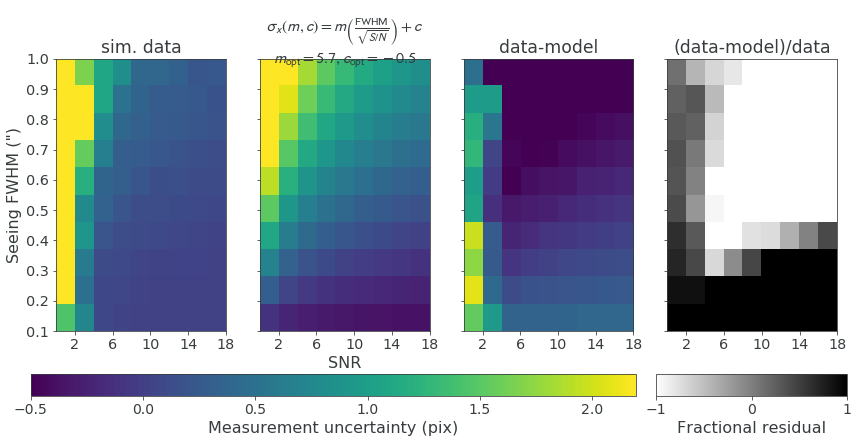

In [141]:
fit_uncertainty_2d_model1()

Optimized parameters are m=34.47, c=0.33


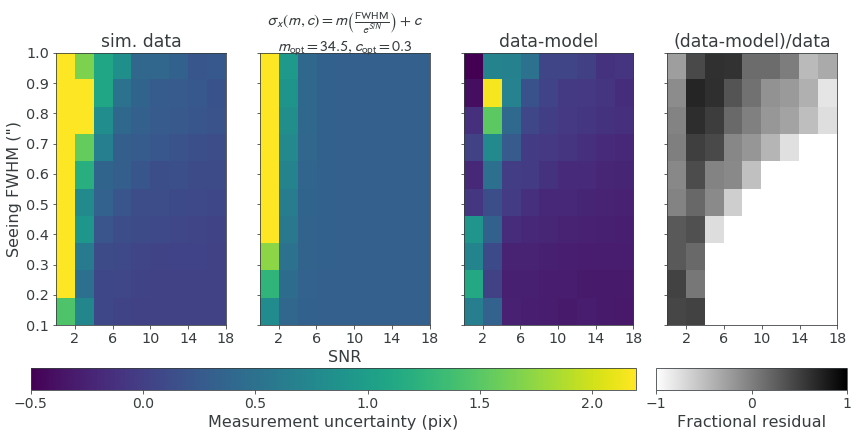

In [142]:
fit_uncertainty_2d_model2()

Optimized parameters are m=13.32,alpha=1.41,c=0.02


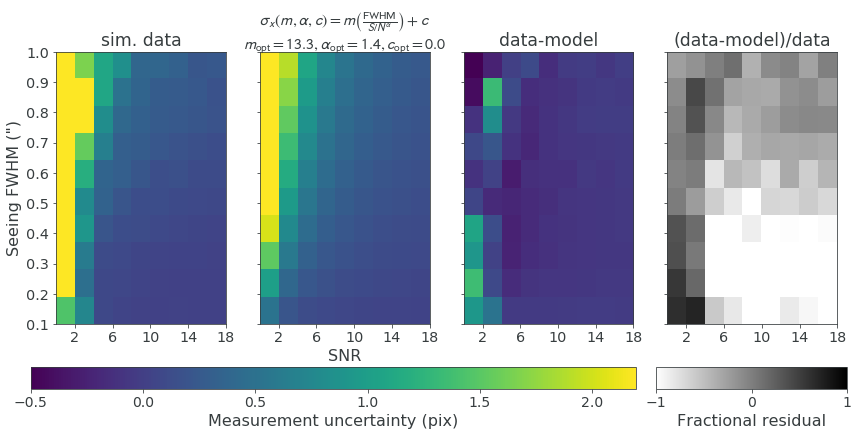

In [143]:
fit_uncertainty_2d_model3()

So the third model seems to perform the best, even though the fit is still not that great. The fit is pretty good for $S/N>5$ and FWHM$>0.5$ which is where most of our data will be anyway, so it seems sufficient to predict $\sigma_{x,\mathrm{msr}}$.
Now we just need to know the seeing values from Laura. I calculate Lya S/N for each object, so I can just feed it to the function.

## 2. Using different seeing values
We can't do that yet because Laura hasn't got back to me with the values yet. But I need to write the likelihood in a way where I can flexibly use different seeing values (to obtain the measurement error using the function I just found).

## 3. Does slit-width matter?
Short answer: **No**. The question is will it matter at all for $dp(x)/dx$. It will never matter as long as $dp(x)/dx$ and $dp(y)/dy$ are separable. And because the slit-loss only depends on $y$, we will always be able to separate the $x$ and $y$ integrals and do the $y$-integral, which will give us a number. This number may depend on the slit-width, but it will never depend on $x$. Because slit-width is the same for all of our spectra, the $y$-integral always results in a constant and therefore does not provide information on $dp(x)/dx$


## Re-writing likelihood to accommodate different measurement errors 
The final step before I am ready to constrain $\sigma_{r,\mathrm{Ly}\alpha}$ is to write the likelihood so I can use different values for the seeing and then use that value and the measured Lya S/N to estimate the $\sigma_{x,\mathrm{msr}}$ using our function we found above.

I updated the mcmc functions to include this information. I also wrote a function which takes FWHM and Lya SNR and returns a measurement uncertainty (not shown here).

Drawing from a uniform distribution of seeing in the range $0.4-1.0$ arcsec and using the actual Lya SNR values from the spectra, I ran an MCMC forecast.

In [129]:
def mcmc_forecast(nwalkers=100,nsteps=250,verbose=True,savechain=True):
    """
    ---- PURPOSE ----
    Make an mcmc forecast for expected range of 
    Seeing FWHM and the given Lya SNR values.
    I didn't yet have seeing FWHM from Laura. 
    This is to make sure I am all set to go once 
    I get the PSFs from her.
    ---- INPUT ----
    uncertainty_pixel       The uncertainty in the spatial centroid in pixels (must assume)
    nwalkers                The number of paths throught the parameter space that are taken. 
                            100 or greater is good
    nsteps                  The number of steps to take in each walker chain.
                            500 recommended on emcee website
    verbose                 If True, will print status updates about run to the screen 
    savechain               If True, will save the mcmc chain to a text file
    ---- OUTPUT ----
    sampler         An object containing information about the mcmc run, including the chain 
    """

    ''' Set up the data '''
    offset_tab = Table.read(offset_cat_gauss,format='ascii.commented_header')
    print "Have %i objects in the original offset table before cleaning" % len(offset_tab)
    ''' Load in the good specfiles from my visual inspection '''
    good_specfiles_tab = Table.read(good_specfiles_file,format='ascii.commented_header')
    good_specfiles = good_specfiles_tab['specfile']
    bad_indices = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] not in good_specfiles]
    offset_tab.remove_rows(bad_indices)
    ''' Now remove the specfiles which I identified as having bad optimized lya positions '''
    bad_specfiles_tab = Table.read(bad_specfiles_file,format='ascii.commented_header')
    bad_specfiles = bad_specfiles_tab['specfile']
    bad_indices2 = [ii for ii in range(len(offset_tab)) if offset_tab['specfile'][ii] in bad_specfiles]
    offset_tab.remove_rows(bad_indices2)
    
    print "Have %i objects in the offset table after cleaning" % len(offset_tab)

    zs_lya = offset_tab['z_lya']
    y_lya_priors = offset_tab['y_lya_prior']
    y_lya_opts = offset_tab['y_lya_opt']
    snr_lya_ints = offset_tab['snr_lya_int']
    
    offsets_pix = y_lya_priors - y_lya_opts
    offsets_arcsec = offsets_pix*pixscale_vimos_spatial
    arcsecs_per_kpc = np.array([cosmo.arcsec_per_kpc_proper(z_lya).value for z_lya in zs_lya])

    offsets_kpc = np.array([offsets_arcsec[ii]/arcsecs_per_kpc[ii] for ii in range(len(offsets_arcsec))])
    ''' Draw seeing FWHMs from a uniform distribution '''
    seeing_fwhms = np.random.uniform(0.4,1.0,size=len(offsets_kpc))

    msr_errors_pix = [msr_uncertainty_func(snr_lya_ints[ii],seeing_fwhms[ii]) \
                for ii in range(len(offsets_kpc))]
    # print snr_lya_ints
    # print msr_errors_pix
    msr_errors_kpc = np.array([np.sqrt(2)*msr_errors_pix[ii]*pixscale_vimos_spatial/arcsecs_per_kpc[ii] \
                for ii in range(len(offsets_kpc))])
    # print msr_errors_kpc

    ''' set up the mcmc parameters '''
    sigma_r_min = 0.1
    sigma_r_max = 5.
  
    ''' Now set up the sampler '''
    ndim = 1
    ''' initialize a Gaussian around the mean of the parameter range  '''
    pos = [np.array([np.mean([sigma_r_min,sigma_r_max])]) + 1e-2*np.random.randn(ndim) \
                for i in range(nwalkers)] 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_4mcmc_tot, args=(offsets_kpc,msr_errors_kpc))
    print "Optimizing for sigma_r_kpc"

    print "running sampler for %i steps with %i walkers" % (nsteps,nwalkers)

    if verbose:
        for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
            print("{0:5.1%}".format(float(i) / nsteps))
    else:
        sampler.run_mcmc(pos,nsteps)

    if savechain:
        savename = mcmc_dir + '/mcmc_chain_nwalkers%i_nsteps%i_forecast.txt' % (nwalkers,nsteps)
        print "saving %s" % savename
        np.savetxt(savename,sampler.flatchain)

    return sampler

In [130]:
# Define plotting function 

def posterior_forecast(show=True,save=False):
    """
    ---- PURPOSE ----
    Plot the posterior of sigma_r_kpc from the output of the mcmc chain
    ---- INPUT ----
    chain_file      The txt file saved in run_mcmc_1D() that has the chain information
    ---- OUTPUT ----
    matplotlib file
    """
    forecast_chain_file = mcmc_dir + '/mcmc_chain_nwalkers100_nsteps250_forecast.txt'
    tab = Table.read(forecast_chain_file,format='ascii.no_header',names=['sigma_r_kpc'])
    sigma_r_kpc_all = tab['sigma_r_kpc']
    ''' need to remove burn-in steps, so first ~30 steps.
    Since the array is flattened along the walker axis,
    the rows in sigma_r_kpc_all for the first 30/nsteps repeating are the burnt-in ones.    '''
    
    nwalkers = 100
    nsteps   = 250

    non_burn_in_mask = np.array([x+np.arange(30,nsteps) for x in range(0,len(sigma_r_kpc_all),nsteps)])
    sigma_r_kpc_noburnin = sigma_r_kpc_all[non_burn_in_mask].flatten()
    med,low,high = confidence_interval(sigma_r_kpc_noburnin)
    higherr = high-med
    lowerr = med-low
    
    if show:
        plt.ion()
    else:
        plt.ioff()
    
    fig=plt.figure()
    ax = fig.add_subplot(1,1,1)
    sigma_r_min = 0.1
    sigma_r_max = 5.
    delta_sigma_r = 0.05
    weights = np.ones_like(sigma_r_kpc_noburnin)/float(len(sigma_r_kpc_noburnin))
    bins=np.arange(sigma_r_min, sigma_r_max, delta_sigma_r)
    posterior,bin_edges,_=ax.hist(sigma_r_kpc_noburnin, weights=weights,bins=bins,alpha=0.75)
    bin_cens = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
    # ax.plot(bin_cens,posterior,linewidth=2,color='r')
    ax.set_xlabel(r'$\sigma_{r,\mathrm{Ly}\alpha}$ [kpc]')
    ax.set_ylabel(r'$p(\sigma_{r,\mathrm{Ly}\alpha}|\{x_i\})$ ')
    # ax.annotate('Assuming\n' + r'$\sigma_{x,\mathrm{msr}} = %.1f$ pix' % uncertainty_pixel,
    #     color='k', xy=(0.5,0.75), xycoords='axes fraction',fontsize=14,horizontalalignment='center',)

    # ax.annotate(r'$\sigma_{r,\mathrm{Ly}\alpha} = %.2f^{+%.2f}_{-%.2f}$' % (med,higherr,lowerr), 
        # color='k', xy=(0.5,0.5),xycoords='axes fraction',fontsize=18,horizontalalignment='center',)
    
    plt.tight_layout()
    if save:
        savename = mcmc_dir + '/posterior_forecast.png'
        plt.savefig(savename,format='png')
        print "Saved %s" % savename


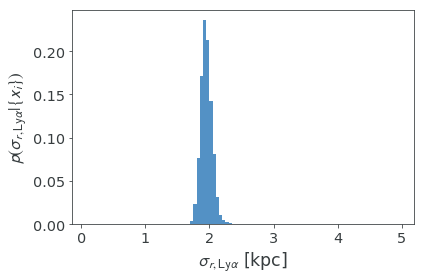

In [131]:
posterior_forecast()

So it looks like we will probably be able to constrain $\sigma_r$ quite well. For reference, 2 kpc at $z=4$ is $\sim0.3$ arcsec. So we can constrain offsets smaller than our seeing, which shows the statistical power of the method.